## Make Plots

cary over the params for the random forest

In [1]:
#this will be an import from the model_test Notebook and collapased. 

# import a few things 
import sys # General sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
plt.style.use('classic')


sys.path.insert(0, "../utils/") # add the path to python so we have relaitve imports

import frames as fm
import date_funcs as datef
import plot_maker as pm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

#Pick an influencer user name
myuser= 'chiaraferragni'

ppdf = fm.make_user_df(myuser) # Take the json for the profile 
pdf = fm.clean_df(ppdf)#clean the json for the scraped and with follower data
ddf = fm.make_vision_df(pdf)# M
df = ddf.dropna()# drop anything that is not file
df = fm.make_label_vision_df(df)# note the datetime error is ok
print df.columns

predf , postdf = datef.make_pre_post_algodf(df)# Break the df into before and after the smartfeed algo 

# Base features we will use in the model
base_feat = ["nfollowers",'post_count','weekday',"ntag",'face_frac','bjlk','bslk','bhlk','balk','bsplk','weekday_hr_6','is_tag','has_title','has_emo',"is_car"]
# features to be one hot encoded
dummy_feat =["weekday_hr_6",'weekday']

predf = predf.sample(frac=1).reset_index(drop=True)# for good measure random shuffle the data frame

# Make test/train samples for pre ,Test Train split with frozen random state
prefeat_df =predf[base_feat]
prefeat_df = pd.get_dummies(prefeat_df, columns=dummy_feat)# This is X aka features
preY = predf["Nlikes"]

#Split the dataframe for cross validation
preX_train, preX_test, prey_train, prey_test = train_test_split(prefeat_df, preY, test_size=0.2, random_state=0)

#postdf = postdf.sample(frac=1).reset_index(drop=True)
postfeat_df =postdf[base_feat]
postfeat_df = pd.get_dummies(postfeat_df, columns=dummy_feat)# This is X aka features
postY = postdf["Nlikes"]

postX_train, postX_test, posty_train, posty_test = train_test_split(postfeat_df, postY, test_size=0.3, random_state=0)
print'We have {} Features in this model.'.format(len(prefeat_df.columns))

/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


Index([u'Nlikes', u'images', u'user', u'uid', u'nfollowers', u'nfollowers_2',
       u'nfollowers_3', u'datetime', u'hour', u'hour_3', u'year', u'weekday',
       u'weekday_hr', u'weekday_hr_3', u'weekday_hr_6', u'has_title',
       u'title_length', u'has_emo', u'title_text', u'emo', u'is_car',
       u'is_loc', u'location', u'is_tag', u'ntag', u'im_id', u'post_count',
       u'nfaces', u'face_frac', u'JLK', u'SLK', u'ALK', u'SPLK', u'HLK',
       u'is_face', u'bjlk', u'balk', u'bslk', u'bsplk', u'bhlk'],
      dtype='object')
We have 48 Features in this model.


In [6]:
#make hist of post likes 
plt.style.use('seaborn-whitegrid')
def make_post_likes_hist(myy):
    plt.figure(figsize=(9,6))
    plt.style.use('seaborn-whitegrid')
    n, bins, pathch = plt.hist(myy,bins=50,color='b', histtype='bar',ec='black')
    plt.title('Histogram of Number of Likes for Chiara Feraggni',size=20)
    plt.xlabel('Number of Likes',size = 20)
    plt.grid(True)
    plt.show()

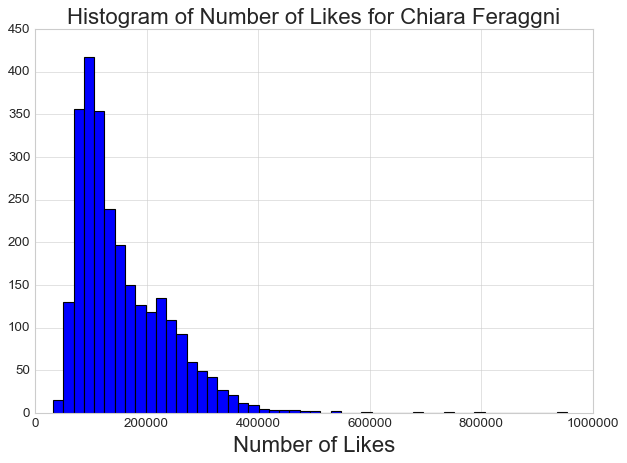

In [7]:
make_post_likes_hist(postY)


8157


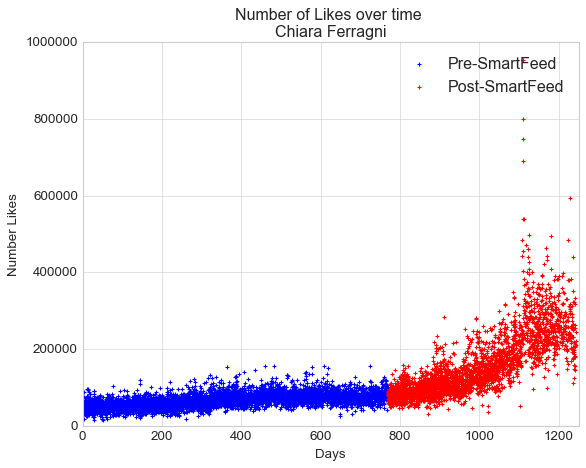

In [20]:
pm.make_date_user_plot(df,myuser)
plt.title("Number of Likes over time \nChiara Ferragni")
plt.ylim(0,1000000)
plt.xlim(0,1250)
plt.show()

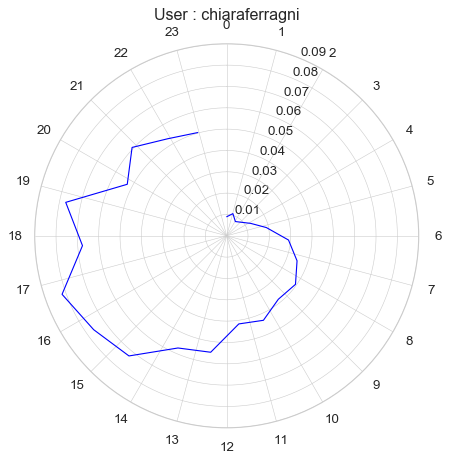

In [22]:
myuser =postdf.groupby("user")
for i, g in myuser:
    mya = np.asarray(g.hour)
    count, division = np.histogram(mya,bins=23,normed=True)
    ax = plt.subplot(111, polar=True)
    equals = np.linspace(0, 360, 23, endpoint=False) #np.arange(24)
    ones = np.ones(23)
    ax.plot(np.deg2rad(equals), count)
    #ax.scatter(np.deg2rad(equals), count)
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels(range(24))
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2.0)
    plt.title("User : {}".format(i))
    plt.show()


In [15]:
def make_feat_imp(myreg,mydf,top=0,dep=15):
    # Get Feature Importance from the classifier
    feature_importance = myreg.feature_importances_
    # Normalize The Features
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(16, 12))
    dep = len(pos)-dep
    top = len(pos)-top
    # Clean up the lists 
    fresh_pos =[x for x in range(len(pos[dep:top]))] 
    fresh_feat = [ x for x in feature_importance[sorted_idx][dep:top]]
    plt.barh(fresh_pos,fresh_feat, align='center', color='r')
    #plt.yticks(pos[dep:top], np.asanyarray(mydf.columns.tolist())[sorted_idx][dep:top])
    plt.xlabel('Relative Importance',size=20)
    plt.title('Feature Importance',size=25)



In [16]:
#make model 
from sklearn.ensemble import  RandomForestRegressor
# {'max_features': 48, 'n_estimators': 1000, 'max_depth': 6}
Post_reg = RandomForestRegressor(n_estimators= 1000, max_features= 48, max_depth= 5)
Post_reg.fit(postX_train, posty_train)
make_feat_imp(Post_reg,postfeat_df,top=2,dep=10)
#plt.ylabel(['Fraction of Face','Sunday','Number of Tags','Is it tagged','Sunday(12pm-6pm)','Emojis'])
#plt.show()

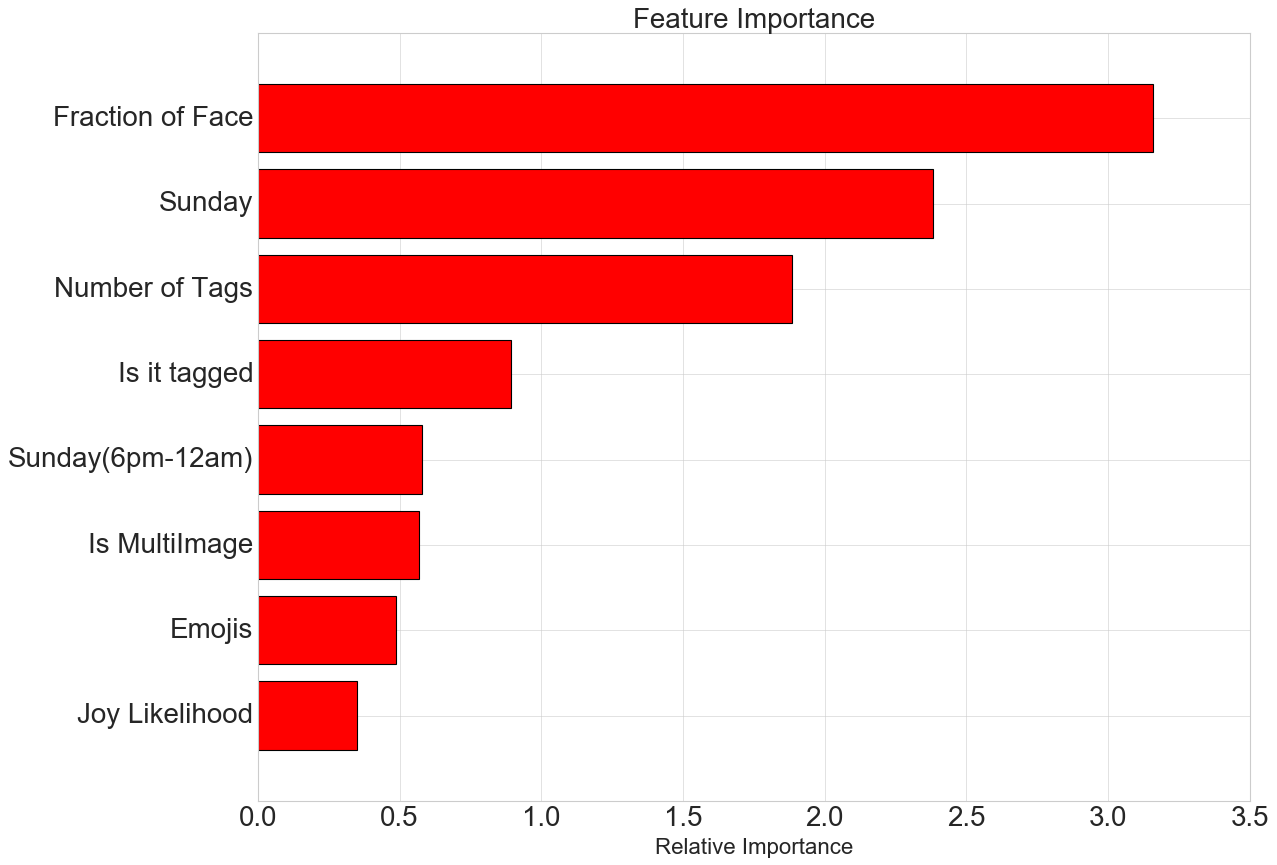

In [17]:
plt.xticks(size=25)
pretty_lab = ['Fraction of Face','Sunday','Number of Tags','Is it tagged','Sunday(6pm-12am)','Is MultiImage','Emojis','Joy Likelihood']
#pretty_lab = ['Fraction of Face','Sunday','Number of Tags','Is it tagged','Sunday(6pm-12am)','Sunday(12pm-6pm)','Sunday','Emojis','Joy Likelihood']
plt.yticks([x for x in range(len(pretty_lab))],pretty_lab[::-1],size=25)
plt.show()


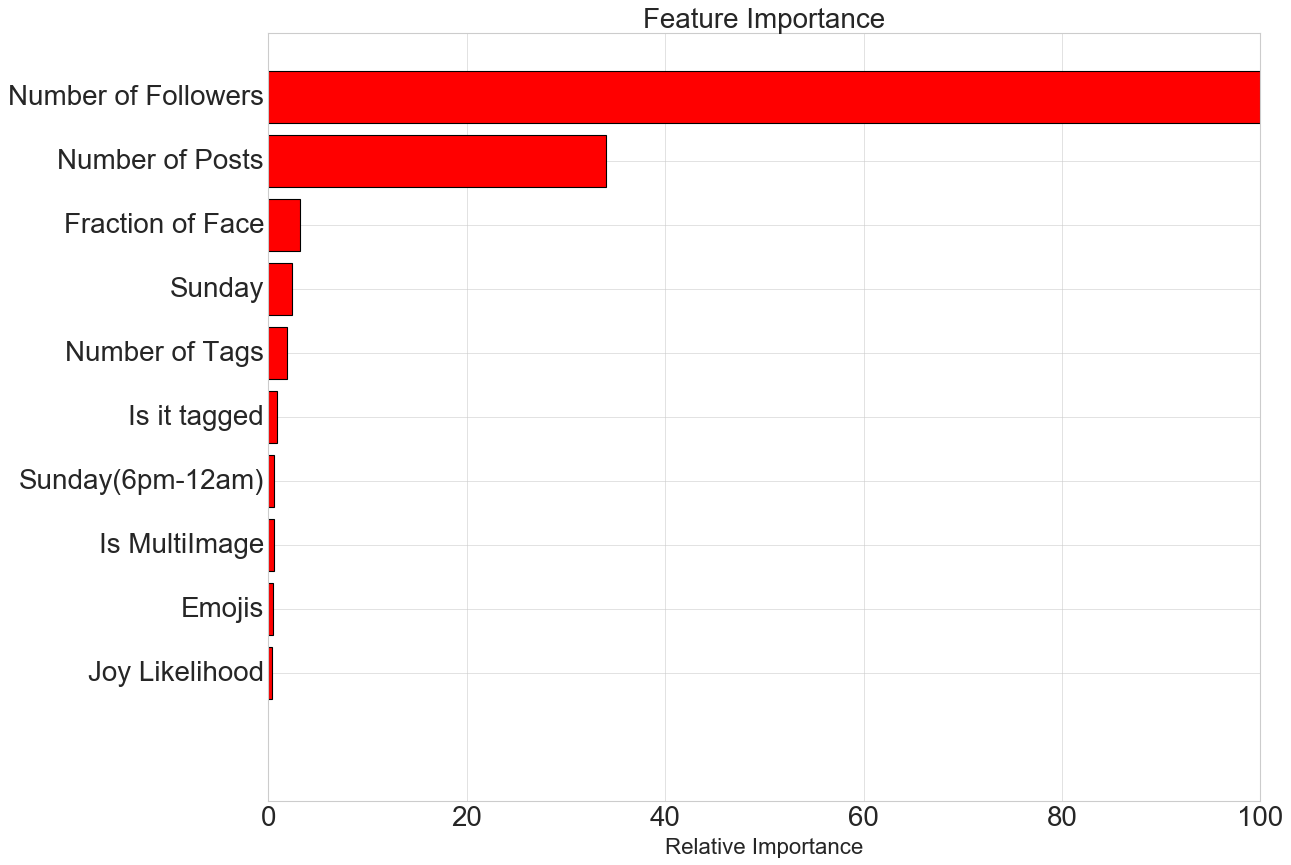

In [18]:
make_feat_imp(Post_reg,postfeat_df,top=0,dep=10)
plt.xticks(size=25)
pretty_lab = ["Number of Followers","Number of Posts",'Fraction of Face','Sunday','Number of Tags','Is it tagged','Sunday(6pm-12am)','Is MultiImage','Emojis','Joy Likelihood']
#pretty_lab = ['Fraction of Face','Sunday','Number of Tags','Is it tagged','Sunday(6pm-12am)','Sunday(12pm-6pm)','Sunday','Emojis','Joy Likelihood']
plt.yticks([x for x in range(len(pretty_lab))],pretty_lab[::-1],size=25)
plt.show()
